# Average Bubble

In [1]:
%matplotlib inline

In [2]:
import os,sys
sys.path.append('/home/dpirvu/python_stuff/')
sys.path.append('./bubbles_codes/')

from plotting import *
from bubble_tools import *
from experiment import *


In [14]:
indList = np.load('./data/list_of_crit_indices.npy')

In [4]:
indList

array([], dtype=float64)

In [5]:
indList+=1

In [6]:
indList

array([], dtype=float64)

In [7]:
bubbleList, velocitesList, instantonList, tmpList, fldcritList, tcritList, encritList = [], [], [], [], [], [], []
for tmp in [0,1,2,3]:
    phi0, temp, lamb, sigmafld, minSim, maxSim, right_Vmax = get_model(tmp)
    exp_params = np.asarray([nLat, lamb, phi0, temp])

    bubbleList.append(np.load(average_file(*exp_params)))
    velocitesList.append(np.load(velocities_file(*exp_params)))
    instantonList.append(np.load(supercrit_instanton_file(*exp_params)))
    tmpList.append(tmp)
    fldcritList.append(np.load(critfield_file(*exp_params)))
    tcritList.append(np.load(crittimes_file(*exp_params)))
    encritList.append(np.load(critenerg_file(*exp_params)))


In [8]:
%run 'bubbles_codes/plotting.py'

In [9]:
def ax_opts(ax):
    ax[0].axhline(phieq, color='darkgray', ls='--')
    ax[0].axhline(2.*np.pi, color='darkgray', ls='--') 
    ax[1].axvline(phieq, color='darkgray', ls='--')
    ax[1].axvline(2.*np.pi, color='darkgray', ls='--') 
    ax[0].yaxis.set_major_locator(plt.MultipleLocator(np.pi/2))
    ax[0].yaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
    ax[1].xaxis.set_major_locator(plt.MultipleLocator(np.pi/2))
    ax[1].xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
    ax[0].set_xlabel(r'$r$')
    ax[0].set_ylabel(r'$\phi$')
    ax[1].set_ylabel(r'$r$')
    ax[1].set_xlabel(r'$\phi$')
    for axx in ax:
        axx.legend()
        axx.grid()
    return ax

In [10]:
allcolors = ['#377eb8', '#ff7f00', 'forestgreen', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


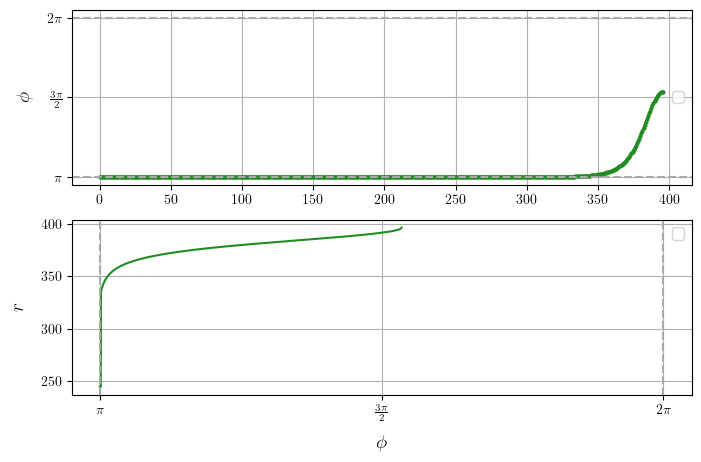

In [11]:
# First, reconstruct potential from instanton solution to check units:

fig, ax = plt.subplots(2, 1, figsize = (8, 5))
col = allcolors[2]

instanton = instantonList[0]
xpeak  = np.argmax(instanton)+1
data   = instanton[:xpeak]
r      = np.linspace(0, xpeak, len(data))*dx

phifv    = data
dphidr   = np.gradient(phifv, dx)
ddphiddr = np.gradient(dphidr, dx)

# invert \phi(r) into r(\phi)
rinv = np.zeros(phifv.shape)
profile = intp.interp1d(r, phifv, kind='linear')
diff = lambda x, a: (profile(x) - a)**2.
for idx, x_value in enumerate(phifv):
    res = sco.minimize_scalar(diff, args=(x_value), bounds=(min(r), max(r)), method='Bounded')
    rinv[idx] = res.x

# integrate product of derivatives above to get potential function of r
dVdr = scp.interpolate.splrep(r, dphidr*ddphiddr)
Vofrofphi = scp.interpolate.splev(rinv, scp.interpolate.splantider(dVdr, n=1))
truereco = np.asarray([r, phifv, dphidr, ddphiddr, Vofrofphi])

ax[0].plot(r,     data , color=col, marker='o', ms=2)
ax[0].plot(r,     phifv, color=col)
ax[1].plot(phifv, rinv , color=col)

ax = ax_opts(ax)
plt.show()

In [13]:
indList

array([], dtype=float64)

IndexError: index 0 is out of bounds for axis 0 with size 0

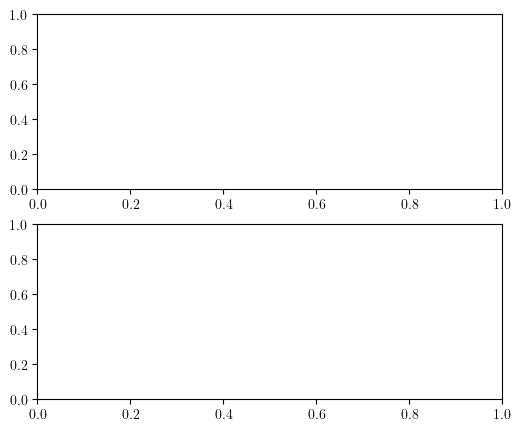

In [12]:
fig, ax = plt.subplots(2, 1, figsize = (6, 5))
cols = cycle(allcolors)
fvrecoList = []
for ii, average_bubble in enumerate(bubbleList):
    tmp = tmpList[ii]
    phi0, temp, lamb, sigmafld, minSim, maxSim, right_Vmax = get_model(tmp)
    exp_params = np.asarray([nLat, lamb, phi0, temp])
    indmin = int(indList[ii])
    col = next(cols)
    
    xmin = 100
    data   = average_bubble[0,0,indmin,xmin:-xmin]

    xpeak  = np.argmax(data)+1
    data   = data[:xpeak]
    r      = np.linspace(1, xpeak, len(data))*dx

    phifv    = data
    dphidr   = np.gradient(phifv, dx)
    ddphiddr = np.gradient(dphidr, dx)

    # invert \phi(r) into r(\phi)
    rinv = np.zeros(phifv.shape)
    profile = intp.interp1d(r, phifv, kind='linear')
    diff = lambda x, a: (profile(x) - a)**2.
    for idx, x_value in enumerate(phifv):
        res = sco.minimize_scalar(diff, args=(x_value), bounds=(min(r), max(r)), method='Bounded')
        rinv[idx] = res.x

    # integrate product of derivatives above to get potential function of r
    dVdr = scp.interpolate.splrep(r, dphidr*ddphiddr)
    Vofrofphi = scp.interpolate.splev(rinv, scp.interpolate.splantider(dVdr, n=1))
    fvrecoList.append(np.asarray([tmp, temp, lamb, phi0, r, phifv, dphidr, ddphiddr, Vofrofphi]))

    labs = r'${}$'.format(round(temp/np.sqrt(m2(lamb)),1))
    lsl = ('-' if tmp==1 else '--' if tmp==0 else ':' if tmp==2 else '-.')

    ax[0].plot(r,     data , color=col, ls=lsl, marker='o', ms=2)
    ax[0].plot(r,     phifv, color=col, ls=lsl, label=labs)
    ax[1].plot(phifv, rinv , color=col, ls=lsl, label=labs)

ax = ax_opts(ax)
ax[0].legend(title=r'$T/m = $', frameon=False, bbox_to_anchor=(1, 1))
ax[1].legend(title=r'$T/m = $', frameon=False, bbox_to_anchor=(1, 1))
plt.show()

In [ ]:
fig, ax = plt.subplots(2, 1, figsize = (6, 5))
for ii, lists in enumerate(fvrecoList):
    tmp, temp, lamb, phi0, r, phifv, dphidr, ddphiddr, Vofrofphi = lists

    lsl = ('-' if tmp==1 else '--' if tmp==0 else ':' if tmp==2 else '-.')

    ax[0].plot(r, phifv-phieq, 'r', ls=lsl, label=(f'$\phi(r)$' if ii==0 else None))
    ax[0].plot(r, dphidr     , 'b', ls=lsl, label=(f'$\partial_r \phi(r)$' if ii==0 else None))
    ax[0].plot(r, ddphiddr   , 'g', ls=lsl, label=(f'$\partial_r^2 \phi(r)$' if ii==0 else None))
    ax[1].plot(r, Vofrofphi  , 'g', ls=lsl, label=(f'$V(r)$' if ii==0 else None))

for axx in ax: axx.set_xlabel(r'$r$'); axx.legend(frameon=False, bbox_to_anchor=(1, 0.8)); axx.grid()
plt.show()


# The Roll 

In [ ]:
fig, ax = plt.subplots(2, 1, figsize = (6, 5))
cols = cycle(allcolors)

rollrecoList = []
for ii, average_bubble in enumerate(bubbleList):
    tmp = tmpList[ii]
    phi0, temp, lamb, sigmafld, minSim, maxSim, right_Vmax = get_model(tmp)
    exp_params = np.asarray([nLat, lamb, phi0, temp])
    indmin = int(indList[ii])
    col = next(cols)

    xpeak  = np.argmax(average_bubble[0,0,indmin])
    data  = average_bubble[0,0][indmin:, xpeak]

    tlist = np.linspace(0, len(data), len(data))*dx

    tstop = np.argmax(data)+1
    data  = data[:tstop+1]
    rt    = tlist[:tstop+1]

    phiroll  = data
    dphidr   = np.gradient(phiroll, dx)
    ddphiddr = np.gradient(dphidr, dx)

    # invert \phi(r) into r(\phi)
    tinv = np.zeros(phiroll.shape)
    profile = intp.interp1d(rt, phiroll, kind='linear')
    difft = lambda x, a: (profile(x) - a)**2.
    for idx, x_value in enumerate(phiroll):
        res = sco.minimize_scalar(difft, args=(x_value), bounds=(min(rt), max(rt)), method='Bounded')
        tinv[idx] = res.x

    dVdr = scp.interpolate.splrep(rt, - dphidr*ddphiddr)
    Vofrofphi = scp.interpolate.splev(tinv, scp.interpolate.splantider(dVdr, n=1))
    rollrecoList.append(np.asarray([tmp, temp, lamb, phi0, rt, phiroll, dphidr, ddphiddr, Vofrofphi]))

    labs = r'${}$'.format(round(temp/np.sqrt(m2(lamb)),1))
    lsl = ('-' if tmp==1 else '--' if tmp==0 else ':' if tmp==2 else '-.')

    ax[0].plot(rt,      data , color=col, ls='None', marker='o', ms=2)
    ax[0].plot(rt,      phiroll, color=col, ls=lsl, label=labs)
    ax[1].plot(phiroll, tinv , color=col, ls=lsl, label=labs)

ax = ax_opts(ax)
ax[0].legend(title=r'$T/m = $', frameon=False, bbox_to_anchor=(1, 1))
ax[1].legend(title=r'$T/m = $', frameon=False, bbox_to_anchor=(1, 1))
plt.show()


In [ ]:
fig, ax = plt.subplots(2, 1, figsize = (6, 5))
for ii, lists in enumerate(rollrecoList):
    tmp, temp, lamb, phi0, ts, phiroll, dphidr, ddphiddr, Vofrofphi = lists

    lsl = ('-' if tmp==1 else '--' if tmp==0 else ':' if tmp==2 else '-.')

    ax[0].plot(ts, phiroll-phieq               , 'r', ls=lsl, label=(f'$\phi(r)$' if ii==0 else None))
    ax[0].plot(ts, dphidr                      , 'b', ls=lsl, label=(f'$\partial_r \phi(r)$' if ii==0 else None))
    ax[0].plot(ts, ddphiddr                    , 'g', ls=lsl, label=(f'$\partial_r^2 \phi(r)$' if ii==0 else None))
    ax[1].plot(ts, Vofrofphi-np.mean(Vofrofphi), 'g', ls=lsl, label=(f'$V(r)$' if ii==0 else None))
    ax[1].plot(ts, -dphidr*ddphiddr            , 'r', ls=lsl, label=(f'$d\phi/drd^2\phi/dr^2$' if ii==0 else None))

for axx in ax: axx.set_xlabel(r'$r$'); axx.legend(frameon=False, bbox_to_anchor=(1, 1)); axx.grid()
plt.show()

# Full reconstruction

In [ ]:
fullRec = []
for ii in range(len(rollrecoList)):
    tmp, temp, lamb, phi0, ts, phiroll, dphidr, ddphiddr, Vrollofrofphi = rollrecoList[ii]
    tmp, temp, lamb, phi0, r, phifv, dphidr, ddphiddr, Vfvofrofphi = fvrecoList[ii]

   # fullRec.append(np.asarray([np.concatenate((phifv, phiroll)), np.concatenate((Vfvofrofphi, Vrollofrofphi))-V(2.*np.pi, lamb)]))
    fullRec.append(np.asarray([phifv, Vfvofrofphi-V(2.*np.pi, lamb)]))


In [ ]:
def fit_to_V(x, lam, nuu, a):
    return (-np.cos(x) + 0.5*lam**2. * np.sin(x)**2. + a) * nuu

fig, ax = plt.subplots(1, 1, figsize = (9, 3))

cols = cycle(allcolors)
#extphi = np.linspace(phieq*0.8, 2.*np.pi*1.1, 100)
extphi = np.linspace(phieq*0.96, phieq*1.55, 100)
for ii in range(len(rollrecoList)+1):
    #if ii==0: continue
    col = next(cols)
    lsl = ('-' if tmp==1 else '--' if tmp==0 else ':' if tmp==2 else '-.')

    if ii==len(rollrecoList):
        r, phifv, dphidr, ddphiddr, Vofrofphi = truereco
        xlist = phifv
        curve = Vofrofphi-V(2.*np.pi, lamb)
        plt.plot(xlist, curve, ls=':', color='r', lw=5, alpha=0.5, label='Instanton Reconstruction')

        popt, _ = scp.optimize.curve_fit(fit_to_V, xlist, curve)
        spline  = scp.interpolate.splrep(extphi, fit_to_V(extphi, *popt))
        seconder= scp.interpolate.splev(phieq, scp.interpolate.splder(spline, n=2))

        plt.plot(extphi, fit_to_V(extphi, *popt), ls=':', color='r', \
                 label=r'$V(\phi, \lambda=%5.2f, m(\lambda)=%5.3f, m=%5.3f)$'%(popt[0], (popt[1]*(-1.+popt[0]**2.))**0.5, seconder**0.5))
    
    else:
        tmp, temp, lamb, phi0, ts, phiroll, dphidr, ddphiddr, Vrollofrofphi = rollrecoList[ii]
        tmp, temp, lamb, phi0, r, phifv, dphidr, ddphiddr, Vfvofrofphi = fvrecoList[ii]
    #    prediction = np.concatenate((V(phifv, lamb), V(phiroll, lamb))) - V(np.pi, lamb)
    #    xlist = np.concatenate((phifv, phiroll))

        prediction = V(phifv, lamb) - V(np.pi, lamb)
        xlist = phifv
        curve = fullRec[ii][1]

        if ii==0:
            plt.plot(xlist, prediction, ls='-', color='k', \
                     label='Bare potential: '+r'$\lambda=%5.1f, m=%5.1f$'%(lamb, m2(lamb)**0.5))

        plt.plot(xlist, curve, color=col, ls=lsl, lw=5, alpha=0.5)

        popt, _ = scp.optimize.curve_fit(fit_to_V, xlist, curve)
        spline  = scp.interpolate.splrep(extphi, fit_to_V(extphi, *popt))
        seconder= scp.interpolate.splev(phieq, scp.interpolate.splder(spline, n=2))

        plt.plot(extphi, fit_to_V(extphi, *popt), color=col, ls=lsl, \
                 label=r'$V(\phi, \lambda=%5.2f, m(\lambda)=%5.3f, m=%5.3f)$'%(popt[0], (popt[1]*(-1.+popt[0]**2.))**0.5, seconder**0.5))

plt.legend(frameon=False, bbox_to_anchor=(1, 1))
plt.xlabel(r'$\bar{\varphi}$')
plt.ylabel(r'$V(\bar{\varphi}; \lambda, m) / \varphi_0^{2}$')
ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
ax.xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
ax.grid(which='both', ls=':', color='lightgray', alpha=0.5)
ax.tick_params(direction='in', which='both', top=True, right=True)
ax.ticklabel_format(axis='y', style='scientific', scilimits=[0.,0.])
ax.xaxis.set_label_coords(0.5, -0.13)
ax.xaxis.set_label_coords(0.5, -0.13)
plt.tight_layout()
plt.savefig('./data/reconstructed_potential.pdf')
plt.show()